In [1]:
import pyxdf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [13]:
def load_data(subject, labels_path):
    data, header = pyxdf.load_xdf(f'{subject}.xdf')
    lables = (pd.read_csv(labels_path)).to_numpy()
    shuffle = (pd.read_csv(f'decoding_data/shuffle_order_{subject}.csv')).to_numpy()
    return data, lables, shuffle

data[1] - eye tracker 

channel 23: x left

channel 24: y left

channel 25: x right

channel 26: y right

data[2] - triggers

In [3]:
def calculate_avg_eye_data(data, p, marker, tobii, num_partitions):
    x_left_avg = []
    y_left_avg = []
    x_right_avg = []
    y_right_avg = []
    triggers = data[marker]['time_stamps']
    for i in range(len(triggers) - 1):
        start = triggers[i]
        end = triggers[i + 1]
        if end - start > 50:
            # break in exp
            continue
        eye_time = data[tobii]['time_stamps']
        flag = 1
        for j in range(len(eye_time)):   
            if eye_time[j] > start and flag:
                first = j
                flag = 0
            elif eye_time[j] > end:
                last = j
                flag = 1
                break
        eye_data = data[tobii]['time_series']
        partition = int(np.round((last - first) / num_partitions))
        x_left_avg.append(np.nanmean(eye_data[0:,23][first + p*partition:first + (p+1)*partition]))
        y_left_avg.append(np.nanmean(eye_data[0:,24][first + p*partition:first + (p+1)*partition]))
        x_right_avg.append(np.nanmean(eye_data[0:,25][first + p*partition:first + (p+1)*partition]))
        y_right_avg.append(np.nanmean(eye_data[0:,26][first + p*partition:first + (p+1)*partition]))
    return x_left_avg, y_left_avg, x_right_avg, y_right_avg

In [ ]:
def set_final_data(shuffle, lables, x_left_avg, y_left_avg, x_right_avg, y_right_avg):
    d = {'label':[], 'x_left':[], 'y_left':[], 'x_right':[],'y_right':[]}
    for idx, image_idx in enumerate(shuffle[:,1]):
        if np.isnan(x_left_avg[idx]) or np.isnan(y_left_avg[idx]) or np.isnan(x_right_avg[idx]) or np.isnan(y_right_avg[idx]):
            continue
        d['label'].append(lables[image_idx][3])
        d['x_left'].append(x_left_avg[idx])
        d['y_left'].append(y_left_avg[idx])
        d['x_right'].append(x_right_avg[idx])
        d['y_right'].append(y_right_avg[idx])
    return pd.DataFrame(data=d)

In [ ]:
def save_final_data(final_data, p, folder, subject):
    final_data.to_csv(f'{folder}/pre_{subject}{p}.csv')

In [ ]:
subject = 'shaked'
marker = 2
tobii = 1
num_partitions = 10
data_folder = 'data'

In [ ]:
# main loop for preprocessing eyes data

data, lables, shuffle = load_data(subject, 'experiment/lables.csv')
for p in range(num_partitions):
    x_left_avg, y_left_avg, x_right_avg, y_right_avg = calculate_avg_eye_data(data, p, marker, tobii, num_partitions)
    final_data = set_final_data(shuffle, lables, x_left_avg, y_left_avg, x_right_avg, y_right_avg)
    save_final_data(final_data, p, data_folder, subject)

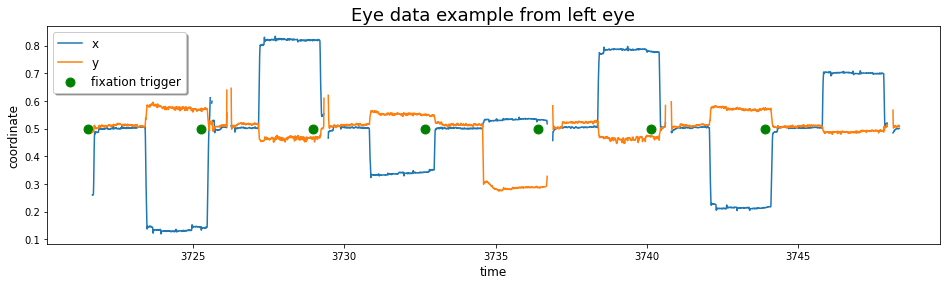

In [29]:
# example of left_gaze_point_on_display_area

plt.figure(figsize=(16, 4))
plt.plot(data[tobii]['time_stamps'][2300:5500], data[tobii]['time_series'][0:,23][2300:5500], label='x')
plt.plot(data[tobii]['time_stamps'][2300:5500], data[tobii]['time_series'][0:,24][2300:5500], label='y')
plt.scatter(data[marker]['time_stamps'][2:9], (data[marker]['time_series'][2:9] / 2), marker='o', color='green', label='fixation trigger', s=80)
plt.xlabel('time', fontsize=12)
plt.ylabel('coordinate', fontsize=12)
plt.legend(loc='best', shadow=True, fontsize='large')
plt.title("Eye data example from left eye", fontsize=18)
plt.savefig("eye_data_example", dpi=400)
plt.show()